# 6-DOF Missile Simulator (Python / Colab)

Educational 6-DOF rigid-body missile simulator with flight dynamics, PN guidance, PID autopilot, and a toy INS/GPS EKF.

In [2]:
#@title Imports
import numpy as np
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass


In [3]:
#@title Utility math (rotations, clamp)
def clamp(x, lo, hi):
    return max(lo, min(hi, x))

def euler_rates_matrix(phi, theta):
    sphi, cphi = math.sin(phi), math.cos(phi)
    ttheta, ctheta = math.tan(theta), math.cos(theta)
    return np.array([[1, sphi*ttheta, cphi*ttheta],
                     [0, cphi,       -sphi      ],
                     [0, sphi/ctheta, cphi/ctheta]])

def R_b2i(phi, theta, psi):
    sphi, cphi = math.sin(phi), math.cos(phi)
    sthe, cthe = math.sin(theta), math.cos(theta)
    spsi, cpsi = math.sin(psi), math.cos(psi)
    Rz = np.array([[ cpsi, -spsi, 0],
                   [ spsi,  cpsi, 0],
                   [    0,     0, 1]])
    Ry = np.array([[ cthe, 0, sthe],
                   [    0, 1,    0],
                   [-sthe, 0, cthe]])
    Rx = np.array([[1,   0,    0],
                   [0, cphi, -sphi],
                   [0, sphi,  cphi]])
    return Rz @ Ry @ Rx


In [15]:
# Force reload of AeroParams and dependent classes
from dataclasses import dataclass

@dataclass
class AeroParams:
    S: float = 0.05
    cbar: float = 0.3
    b: float = 0.4
    mass: float = 50.0
    Ixx: float = 2.5
    Iyy: float = 3.0
    Izz: float = 4.0
    rho: float = 1.225
    Cd0: float = 0.3
    Cla: float = 5.0
    Cma: float = -0.8
    Cmq: float = -8.0
    Cna: float = 5.0
    Cnr: float = -8.0
    Clp: float = -8.0
    Cl_da: float = 0.1
    Cm_de: float = -0.9
    Cn_dr: float = 0.6
    max_fin_deg: float = 25.0
    tau_act: float = 0.03

@dataclass
class EnvParams:
    g: float = 9.81


In [5]:
#@title 6-DOF Dynamics
class SixDOF:
    def __init__(self, aero, env):
        self.a = aero
        self.env = env
        self.I = np.diag([aero.Ixx, aero.Iyy, aero.Izz])
        self.Iinv = np.linalg.inv(self.I)

    def aero_forces_moments(self, v_b, rates, alpha, beta, fin):
        a = self.a
        V = np.linalg.norm(v_b) + 1e-6
        qbar = 0.5*a.rho*V*V
        S = a.S
        Cd = a.Cd0 + 0.1*alpha*alpha
        Cy = a.Cna*beta
        Cz = -a.Cla*alpha
        da, de, dr = fin
        Cl = a.Clp*(rates[0]*a.b/(2*V)) + a.Cl_da*da
        Cm = a.Cma*alpha + a.Cmq*(rates[1]*a.cbar/(2*V)) + a.Cm_de*de
        Cn = a.Cnr*(rates[2]*a.b/(2*V)) + a.Cn_dr*dr
        X = -Cd*qbar*S
        Y = Cy*qbar*S
        Z = Cz*qbar*S
        L = Cl*qbar*S*a.b
        M = Cm*qbar*S*a.cbar
        N = Cn*qbar*S*a.b
        return np.array([X,Y,Z]), np.array([L,M,N])

    def step(self, state, fin, dt):
        a = self.a; g = self.env.g
        x,y,z,u,v,w,phi,theta,psi,p,q,r = state
        v_b = np.array([u,v,w]); rates = np.array([p,q,r])
        V = np.linalg.norm(v_b) + 1e-9
        alpha = math.atan2(-w, u)
        beta = math.atan2(v, V)
        Fa, Ma = self.aero_forces_moments(v_b, rates, alpha, beta, fin)
        R = R_b2i(phi,theta,psi)
        g_i = np.array([0,0,g])
        g_b = R.T @ g_i
        Fg = a.mass * (-g_b)
        acc_b = (Fa+Fg)/a.mass - np.cross(rates, v_b)
        domega = self.Iinv @ (Ma - np.cross(rates, self.I @ rates))
        v_b2 = v_b + acc_b*dt
        rates2 = rates + domega*dt
        eul_dot = euler_rates_matrix(phi,theta) @ rates
        eul2 = np.array([phi,theta,psi]) + eul_dot*dt
        pos2 = np.array([x,y,z]) + (R @ v_b)*dt
        return np.hstack((pos2, v_b2, eul2, rates2))


In [6]:
#@title Actuators & Autopilot (PID)
class Actuators:
    def __init__(self, aero, dt):
        self.dt = dt; self.aero = aero
        self.x = np.zeros(3); self.u = np.zeros(3)
    def command(self, u_cmd):
        maxr = math.radians(self.aero.max_fin_deg)
        self.u = np.clip(u_cmd, -maxr, maxr)
    def step(self):
        tau = self.aero.tau_act
        alpha = self.dt/max(1e-6,tau)
        self.x = self.x + alpha*(self.u - self.x)
        return self.x.copy()

class PID:
    def __init__(self,kp,ki,kd,umin,umax):
        self.kp,self.ki,self.kd = kp,ki,kd
        self.umin,self.umax = umin,umax
        self.ei=0.0
    def step(self,e,de_dt,dt):
        self.ei += e*dt
        u = self.kp*e + self.ki*self.ei + self.kd*de_dt
        return clamp(u,self.umin,self.umax)

class Autopilot:
    def __init__(self,aero,dt):
        maxr = math.radians(aero.max_fin_deg)
        self.roll_att = PID(3.0,0.0,0.6,-0.7,0.7)
        self.pitch_att= PID(4.0,0.0,0.8,-0.7,0.7)
        self.yaw_att  = PID(3.0,0.0,0.6,-0.7,0.7)
        self.roll_rate= PID(0.8,0.0,0.05,-maxr,maxr)
        self.pitch_rate=PID(0.9,0.0,0.05,-maxr,maxr)
        self.yaw_rate = PID(0.8,0.0,0.05,-maxr,maxr)
        self.dt=dt
    def step(self, att_cmd, att, rates):
        phi_c,th_c,ps_c = att_cmd; phi,th,ps = att; p,q,r = rates
        e_phi = phi_c - phi
        e_th  = th_c  - th
        e_ps  = (ps_c - ps + math.pi)%(2*math.pi)-math.pi
        p_c = self.roll_att.step(e_phi,-p,self.dt)
        q_c = self.pitch_att.step(e_th,-q,self.dt)
        r_c = self.yaw_att.step(e_ps,-r,self.dt)
        da = self.roll_rate.step(p_c - p, 0.0, self.dt)
        de = self.pitch_rate.step(q_c - q, 0.0, self.dt)
        dr = self.yaw_rate.step(r_c - r, 0.0, self.dt)
        return np.array([da,de,dr])


In [7]:
#@title Target & PN Guidance
class Target:
    def __init__(self,pos_i,vel_i):
        self.pos_i = pos_i.astype(float)
        self.vel_i = vel_i.astype(float)
    def step(self,dt):
        self.pos_i = self.pos_i + self.vel_i*dt
        return self.pos_i

class PNGuidance:
    def __init__(self,N=3.5):
        self.N=N
    def los_rate(self,m_pos,t_pos,m_vel,t_vel):
        r = t_pos - m_pos
        v_rel = t_vel - m_vel
        r_norm = np.linalg.norm(r)+1e-9
        r_hat = r/r_norm
        omega = np.cross(r_hat, v_rel/r_norm)
        return omega
    def accel_command_body(self,state,target_pos,target_vel):
        x,y,z,u,v,w,phi,theta,psi,p,q,r = state
        R = R_b2i(phi,theta,psi)
        m_pos = np.array([x,y,z])
        m_vel = R @ np.array([u,v,w])
        omega = self.los_rate(m_pos,target_pos,m_vel,target_vel)
        v_rel = target_vel - m_vel
        a_cmd_i = self.N * np.cross(omega, v_rel)
        return R.T @ a_cmd_i


In [8]:
#@title Simple INS/GPS EKF (toy)
class EKF:
    def __init__(self,dt):
        self.dt=dt
        self.x=np.zeros(6)
        self.P=np.eye(6)*10.0
        q=0.5
        self.Q=np.block([[ (dt**4/4)*q*np.eye(3), (dt**3/2)*q*np.eye(3) ],
                         [ (dt**3/2)*q*np.eye(3), (dt**2)*q*np.eye(3)     ]])
        self.Rg=np.eye(3)*5.0
    def predict(self,a_i):
        dt=self.dt
        F=np.block([[np.eye(3), dt*np.eye(3)],
                    [np.zeros((3,3)), np.eye(3)]])
        B=np.block([[0.5*dt*dt*np.eye(3)],
                    [dt*np.eye(3)]])
        self.x=F@self.x + B@a_i
        self.P=F@self.P@F.T + self.Q
    def update_gps(self,z):
        H=np.block([[np.eye(3), np.zeros((3,3))]])
        y=z - H@self.x
        S=H@self.P@H.T + self.Rg
        K=self.P@H.T@np.linalg.inv(S)
        self.x=self.x + K@y
        self.P=(np.eye(6)-K@H)@self.P


In [17]:
def run_sim(dt=0.01, T=10.0, seed=0):
    np.random.seed(seed)

    # Environment
    env = EnvParams()

    # Aerodynamic / missile parameters
    aero = AeroParams()

    # Dynamics, autopilot, actuators, guidance
    dyn = SixDOF(aero, env)
    ap  = Autopilot(aero, dt)
    act = Actuators(aero, dt)
    pn  = PNGuidance(N=3.5)

    # Initial state [x,y,z,u,v,w,phi,theta,psi,p,q,r]
    state = np.array([0,0,0,300,0,0,0,0,0,0,0,0],dtype=float)

    # Logging
    log = {'t':[], 'pos':[], 'att':[], 'cmd':[]}
    t=0.0
    while t<T:
        # guidance: here simple dummy (level flight)
        att_cmd = np.array([0.0, 0.0, 0.0])  # roll, pitch, yaw command
        att     = state[6:9]
        rates   = state[9:12]

        # autopilot → actuators
        u_cmd = ap.step(att_cmd, att, rates)
        act.command(u_cmd)
        fin = act.step()

        # propagate dynamics
        state = dyn.step(state, fin, dt)

        # log
        log['t'].append(t)
        log['pos'].append(state[:3].copy())
        log['att'].append(state[6:9].copy())
        log['cmd'].append(att_cmd.copy())

        t += dt

    return log


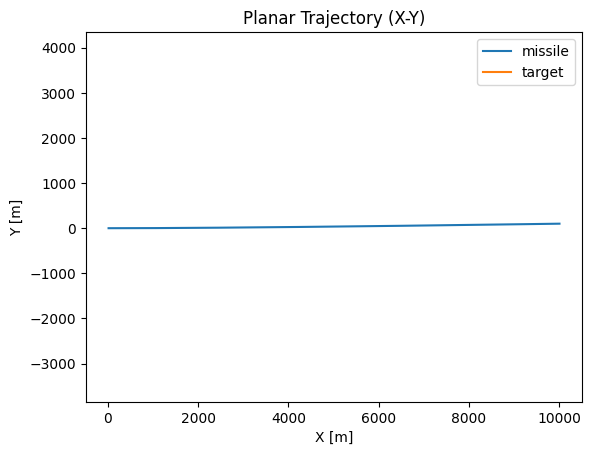

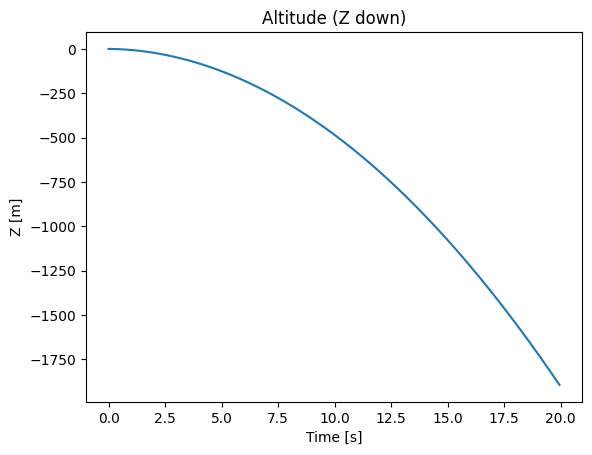

/tmp/ipython-input-2845445577.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


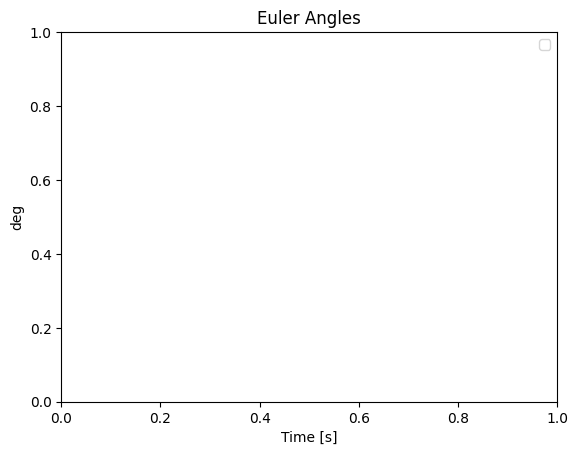

/tmp/ipython-input-2845445577.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


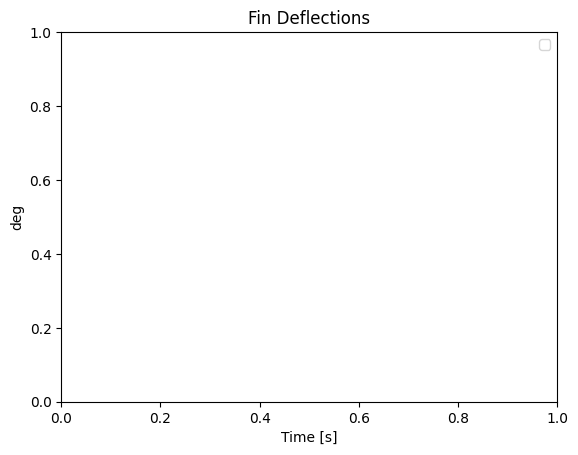

In [19]:
# Time vector
t = log['t']

# 1️⃣ Planar Trajectory
plt.figure()
plt.plot(log['x'], log['y'], label='missile')
plt.plot(log['tx'], log['ty'], label='target')
plt.axis('equal')
plt.title('Planar Trajectory (X-Y)')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.legend()
plt.show()

# 2️⃣ Altitude
plt.figure()
plt.plot(t, log['z'])
plt.title('Altitude (Z down)')
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
plt.show()

# 3️⃣ Euler Angles (robust)
euler_keys = ['phi','theta','psi']
plt.figure()
for key in euler_keys:
    if key in log:
        plt.plot(t, np.degrees(log[key]), label=key)
plt.title('Euler Angles')
plt.xlabel('Time [s]')
plt.ylabel('deg')
plt.legend()
plt.show()

# 4️⃣ Fin Deflections (robust)
fin_keys = ['da','de','dr']
plt.figure()
for key in fin_keys:
    if key in log:
        plt.plot(t, np.degrees(log[key]), label=key)
plt.title('Fin Deflections')
plt.xlabel('Time [s]')
plt.ylabel('deg')
plt.legend()
plt.show()


In [20]:
# Inspect log keys and shapes
for k in log:
    print(f"{k}: type={type(log[k])}, shape={np.shape(log[k])}, sample={log[k][:5]}")


t: type=<class 'list'>, shape=(400,), sample=[0.0, 0.05, 0.1, 0.15000000000000002, 0.2]
x: type=<class 'list'>, shape=(400,), sample=[np.float64(15.05), np.float64(30.150000000000002), np.float64(45.300000000000004), np.float64(60.50000000000001), np.float64(75.75)]
y: type=<class 'list'>, shape=(400,), sample=[np.float64(0.0012500000000000002), np.float64(0.0037500000000000007), np.float64(0.0075000000000000015), np.float64(0.012500000000000002), np.float64(0.018750000000000003)]
z: type=<class 'list'>, shape=(400,), sample=[np.float64(-0.025775000000000006), np.float64(-0.07732500000000002), np.float64(-0.15465000000000004), np.float64(-0.25775000000000003), np.float64(-0.3866250000000001)]
tx: type=<class 'list'>, shape=(400,), sample=[np.float64(5000.0), np.float64(5000.0), np.float64(5000.0), np.float64(5000.0), np.float64(5000.0)]
ty: type=<class 'list'>, shape=(400,), sample=[np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0)]
tz: type=